In [1]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')
 

import os 
import numpy as np
import pandas as pd
import seaborn as sns
from torchsummary import summary
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, mean_squared_error


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Global variables
inpDir = '../input' # Input Stored here
outDir = '../output' # output Here
modelDir = './models'# to save Models
subDir = 'checkpoints' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)



BATCH_SIZE = 64
NOISE = 0.2 
ALPHA = 0.001 
EPOCHS = 45
TEST_SIZE = 0.2

In [4]:
#set the plotting parameters
params = {
    'legend.fontsize': 'medium',
    'figure.figsize':(15,6),
    'axes.labelsize':'medium',
    'axes.titlesize':'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize':'medium',
    #'text.usetex':True,
}
plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


$$\text{
    Load Weather Data
}$$

In [5]:
file_loc = 'text_gen\shakespeare.txt'
file_path = os.path.join(inpDir,file_loc)

text = open(file_path, 'rb').read().decode(encoding='utf-8')

text[:100]

'First Citizen:\r\nBefore we proceed any further, hear me speak.\r\n\r\nAll:\r\nSpeak, speak.\r\n\r\nFirst Citize'

$$
\text {Character Based Modelling}
$$

In [6]:
vocab = sorted(set(text))

len(vocab)

66

In [7]:
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = np.array(vocab)

In [8]:
char2idx

{'\n': 0,
 '\r': 1,
 ' ': 2,
 '!': 3,
 '$': 4,
 '&': 5,
 "'": 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '3': 10,
 ':': 11,
 ';': 12,
 '?': 13,
 'A': 14,
 'B': 15,
 'C': 16,
 'D': 17,
 'E': 18,
 'F': 19,
 'G': 20,
 'H': 21,
 'I': 22,
 'J': 23,
 'K': 24,
 'L': 25,
 'M': 26,
 'N': 27,
 'O': 28,
 'P': 29,
 'Q': 30,
 'R': 31,
 'S': 32,
 'T': 33,
 'U': 34,
 'V': 35,
 'W': 36,
 'X': 37,
 'Y': 38,
 'Z': 39,
 'a': 40,
 'b': 41,
 'c': 42,
 'd': 43,
 'e': 44,
 'f': 45,
 'g': 46,
 'h': 47,
 'i': 48,
 'j': 49,
 'k': 50,
 'l': 51,
 'm': 52,
 'n': 53,
 'o': 54,
 'p': 55,
 'q': 56,
 'r': 57,
 's': 58,
 't': 59,
 'u': 60,
 'v': 61,
 'w': 62,
 'x': 63,
 'y': 64,
 'z': 65}

In [9]:
text_as_int = np.array([char2idx[c] for c in text])
text_as_int.shape

(1155396,)

In [10]:
seq_len = 100
example_per_epoch = len(text) / seq_len+1

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(20):
    print(i.numpy(), end=' : ')
    print(idx2char[i.numpy()])


19 : F
48 : i
57 : r
58 : s
59 : t
2 :  
16 : C
48 : i
59 : t
48 : i
65 : z
44 : e
53 : n
11 : :
1 : 
0 : 

15 : B
44 : e
45 : f
54 : o


In [11]:
sequences = char_dataset.batch(seq_len+1, drop_remainder=True)

for item in sequences.take(2):
    print(item)
    print(repr(''.join(idx2char[item.numpy()])))

tf.Tensor(
[19 48 57 58 59  2 16 48 59 48 65 44 53 11  1  0 15 44 45 54 57 44  2 62
 44  2 55 57 54 42 44 44 43  2 40 53 64  2 45 60 57 59 47 44 57  7  2 47
 44 40 57  2 52 44  2 58 55 44 40 50  9  1  0  1  0 14 51 51 11  1  0 32
 55 44 40 50  7  2 58 55 44 40 50  9  1  0  1  0 19 48 57 58 59  2 16 48
 59 48 65 44 53], shape=(101,), dtype=int32)
'First Citizen:\r\nBefore we proceed any further, hear me speak.\r\n\r\nAll:\r\nSpeak, speak.\r\n\r\nFirst Citizen'
tf.Tensor(
[11  1  0 38 54 60  2 40 57 44  2 40 51 51  2 57 44 58 54 51 61 44 43  2
 57 40 59 47 44 57  2 59 54  2 43 48 44  2 59 47 40 53  2 59 54  2 45 40
 52 48 58 47 13  1  0  1  0 14 51 51 11  1  0 31 44 58 54 51 61 44 43  9
  2 57 44 58 54 51 61 44 43  9  1  0  1  0 19 48 57 58 59  2 16 48 59 48
 65 44 53 11  1], shape=(101,), dtype=int32)
':\r\nYou are all resolved rather to die than to famish?\r\n\r\nAll:\r\nResolved. resolved.\r\n\r\nFirst Citizen:\r'


In [12]:
def split_intput_target(chunk):
    input_text = chunk[:-1]  # First hundred charater
    target_text = chunk[1:]  # Last character
    return input_text, target_text


dataset = sequences.map(split_intput_target)

for inp_epx, tar_epx in dataset.take(2):
    print(repr(''.join(idx2char[inp_epx.numpy()])))
    print(repr(''.join(idx2char[tar_epx.numpy()])))

'First Citizen:\r\nBefore we proceed any further, hear me speak.\r\n\r\nAll:\r\nSpeak, speak.\r\n\r\nFirst Citize'
'irst Citizen:\r\nBefore we proceed any further, hear me speak.\r\n\r\nAll:\r\nSpeak, speak.\r\n\r\nFirst Citizen'
':\r\nYou are all resolved rather to die than to famish?\r\n\r\nAll:\r\nResolved. resolved.\r\n\r\nFirst Citizen:'
'\r\nYou are all resolved rather to die than to famish?\r\n\r\nAll:\r\nResolved. resolved.\r\n\r\nFirst Citizen:\r'


In [13]:
BUFFRE_SIZE = 10000

dataset = dataset.shuffle(BUFFRE_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int32, name=None), TensorSpec(shape=(64, 100), dtype=tf.int32, name=None))>

In [14]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [15]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(None,), batch_size=batch_size),
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            stateful=True,
            kernel_initializer='glorot_uniform',
            recurrent_initializer='orthogonal',
        ),
        tf.keras.layers.Dense(vocab_size)
    ])


In [16]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, None, 256)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, None, 1024)       │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, None, 66)         │        67,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,022,850 (15.35 MB)

 Trainable params: 4,022,850 (15.35 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Unit Testing, Check for models health withount trianing
for inp_ex, tar_ex in dataset.take(1):
    ex_pred = model(inp_ex)
    

In [19]:
ex_pred.shape

TensorShape([64, 100, 66])

In [20]:
sample_indices = tf.random.categorical(ex_pred[0], num_samples=1)
print(sample_indices.shape)

(100, 1)


In [21]:
sample_indices = tf.squeeze(sample_indices, axis=-1).numpy()
print(sample_indices)
print(repr(''.join(idx2char[sample_indices])))

[22 13 13  8 17 41 35 50 47 59 43 33 44 45 14 23 14 32 46 24 43 17 50 19
 23 14 64 55 19 21 43 54 46 51 48 28 61 20 12  0 37 20 44 20 29 47 46 43
 59 16 25  9 54 34 20 63 37 62 44 49 11 61 48 58 46 12 12 36 62 16 56 55
 39 54 28 25 46 59  8 45  9 27 28 10 48 22 14 34 54 38 52 15 41  8 56 54
 21 34 58 47]
'I??-DbVkhtdTefAJASgKdDkFJAypFHdogliOvG;\nXGeGPhgdtCL.oUGxXwej:visg;;WwCqpZoOLgt-f.NO3iIAUoYmBb-qoHUsh'


In [22]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [23]:
model.compile(
    optimizer = 'adam',
    loss = loss_fn,
    metrics = [
        'accuracy'
    ]
)

In [24]:
check_point_path = os.path.join(outDir, subDir)
check_point_prefix = os.path.join(check_point_path, "checkpoint-{epoch}.keras")
check_point_prefix

'../output\\checkpoints\\checkpoint-{epoch}.keras'

In [25]:
check_point_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=check_point_prefix,
)

In [26]:
history = model.fit(
    dataset,
    epochs =EPOCHS,
    callbacks = [check_point_callback],
    verbose = 1,
)

Epoch 1/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 179s 988ms/step - accuracy: 0.2601 - loss: 2.9763
Epoch 2/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.4557 - loss: 1.8562
Epoch 3/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.5291 - loss: 1.5904
Epoch 4/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.5646 - loss: 1.4523
Epoch 5/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5840 - loss: 1.3766
Epoch 6/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.5967 - loss: 1.3229
Epoch 7/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.6067 - loss: 1.2828
Epoch 8/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.6172 - loss: 1.2422
Epoch 9/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.6265 - loss: 1.2118
Epoch 10/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.6338 - loss: 1.1822
Epoch 11/45
178/178 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.6421 - loss: 1.1522
Epoch 12/45
178/178 ━━━━━━━━━━━━━━━━━━

In [27]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss
0,0.341565,2.419445
1,0.477397,1.778329
2,0.538761,1.554239
3,0.567398,1.440646
4,0.585278,1.370458


In [28]:
# Min loss
loss_df.loc[loss_df['loss'] ==loss_df['loss'].min()]

,accuracy,loss
44,0.819941,0.630191


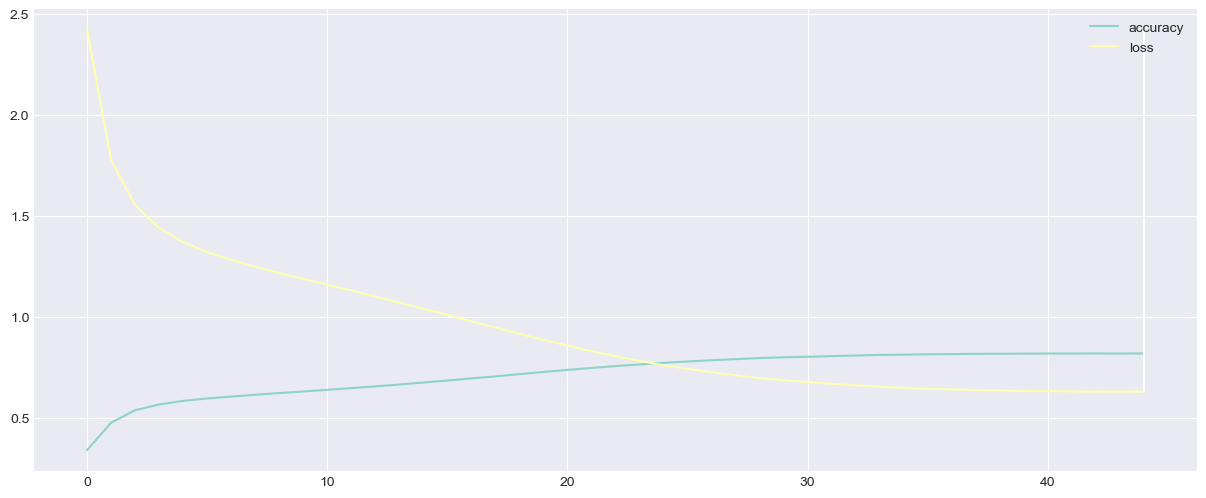

In [29]:
ax = loss_df.plot()
ax.vlines(
    loss_df.loc[loss_df['loss'] ==loss_df['loss'].min()].index,
    ymin=loss_df.loc[loss_df['loss'] ==loss_df['loss'].min()].values[0][1],
    ymax=loss_df.loc[loss_df['loss'] ==loss_df['loss'].max()].values[0][1],
) 

$$
\text{Best model}
$$

In [31]:
# Best model
num = loss_df.loc[loss_df['loss'] ==loss_df['loss'].min()].index.to_numpy()[0]
# Fabricate full path
check_point_weight_path = os.path.join(check_point_path, f"checkpoint-{num}.keras")
check_point_weight_path

'../output\\checkpoints\\checkpoint-44.keras'

In [33]:
# initintalize new model
model1 = build_model(
    vocab_size=vocab_size, 
    embedding_dim=embedding_dim, 
    rnn_units=rnn_units, 
    batch_size=1
)

model1.load_weights(check_point_weight_path)
model1.build(tf.TensorShape([1, None]))

model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, None, 256)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (1, None, 1024)        │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, None, 66)          │        67,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,022,850 (15.35 MB)

 Trainable params: 4,022,850 (15.35 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
def generate_text(model, start_sting):
    num_generate = 1000
    # Getting indices for start string
    input_eval = [char2idx[s] for s in start_sting] # List construct
    print(input_eval)
    input_eval = tf.expand_dims(input_eval, 0) # Size [1,1,5]
    print(input_eval)
    # store generated text
    generated_text = []
    for i in range(num_generate):
        prediction = model(input_eval)
        prediction = tf.squeeze(prediction,0)
        # this is where rummer meets the road
        prediction_td = tf.random.categorical(prediction, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([prediction_td],0)
        generated_text.append(idx2char[prediction_td])
    return start_sting + ''.join(generated_text)

In [50]:
print(generate_text(model=model1, start_sting='ROMEO:'))

[31, 28, 26, 18, 28, 11]
tf.Tensor([[31 28 26 18 28 11]], shape=(1, 6), dtype=int32)
ROMEO:
She hath it strangling stuff.

SLY:
Ah, turn thy marriage! Why call him not? king hen,
If he be married.
Who told me I trGHOO:
Oet is great;
The eyes of heaven.
Resumely benier what I say, my loving friend,
That banest his man was gentle cousin; I must were
vistress, let me ha's to be married?

SAMPSON:
I do; and by the world require you to my gravies,
And doth the young prince yourself with kindes cere,
With such father is grown so bite:
I do not like these saltriey indeed.
Your hugsnidered.

First Servant:
O, think it, is it so; good city Clarence, I'll creep a miswrain?
Would lie upon their backward of Montague,
Stand all alaughter and some feeding.

DUKE:
I strew no other, play.

LEONTES:
Thou wilt fall backward what sir?

PO:
If now I hope thee mark our marriage, night,
Though I have said with me:
For then our soldiers are in reason; that is, I
would have your dispersed by me that royal pre